# Experimentos Doc2Vec

## Referências primárias:
- Paper Mikolov Doc2Vec: https://arxiv.org/pdf/1405.4053v2.pdf
- Explicação teórica breve e exemplo de código: https://towardsdatascience.com/understand-how-to-transfer-your-paragraph-to-vector-by-doc2vec-1e225ccf102
- Documentação/exemplo gensim: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
- Exemplo de código para tarefa de classificação multi-classe: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
- Exemplo de código para tarefa de classificação / análise de sentimentos: http://linanqiu.github.io/2015/10/07/word2vec-sentiment/
- Análise de perfomance frente a modelos Word2Vec com classificadores SVM: https://content.sciendo.com/view/journals/icas/1/1/article-p496.xml

## Briefing teórico
- Doc2Vec se diferencia da abordagem Word2Vec ao não apenas computar palavras como vetores, mas também ao computar todas as palavras de uma sentença em vetores.
- Mikolov dispõe duas abordagens possíveis, inspiradas nos procedimentos usados em Word2Vec, CBOW e Skip-gram:
    - Distributed Memory Model of Paragraph Vectors (PV-DM) - inspirada em Word2Vec CBOW
    - Distributed Bag of Words version of Paragraph Vector (PV-DBOW) - inspirada em Word2Vec Skip-gram

- Na abordagem Distributed Memory Model of Paragraphs Vectors (PV-DM), cada sentença é mapeada em um vetor único, representado por uma coluna em uma matriz D (Document), e cada palavra é também mapeada a um vetor único, representado por uma coluna em uma matriz W (Word). O vetor de sentença e os vetores de palavras são usados para predizer a próxima palavra no contexto, via média e/ou concatenação. Esse procedimento é similar ao CBOW de Word2Vec.

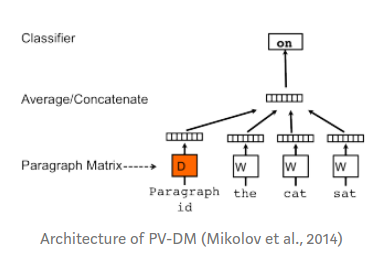

In [20]:
from IPython.display import Image
Image(filename="imgs/doc2vec_dm.png", width=400, height=400)

# imagem disponível em https://arxiv.org/pdf/1405.4053v2.pdf

- A abordagem Distributed Bag of Words version of Paragraph Vector (PV-DBOW) ignora o contexto das palavras de entrada e força o modelo a predizer palavras aleatoriamente selecionadas da sentença de saída. Na prática, isso significa que a cada iteração do SGD (Stochastic Gradient Descent), é selecionada uma janela de texto; então é escolhida aleatoriamente uma palavra dessa janela de texto. A partir de então é formada uma tarefa de classificação dado o vetor de sentença. Esse procedimento é similar ao Skip-gram de Word2Vec.

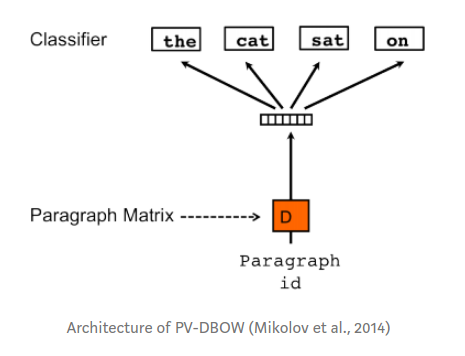

In [21]:
from IPython.display import Image
Image(filename="imgs/doc2vec_dbow.png", width=400, height=400)

# imagem disponível em https://arxiv.org/pdf/1405.4053v2.pdf

## Código

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path_to_text_train = '/home/mstauffer/Documentos/UnB/9º Semestre/KnEDle/sprints/5_27_maio-03_junho/luz_de_araujo_etal_propor2020/data/clean/train.csv'
dt_train = pd.read_csv(path_to_text_train, encoding='utf-8')#[['v1', 'v2']]
path_to_text_val = '/home/mstauffer/Documentos/UnB/9º Semestre/KnEDle/sprints/5_27_maio-03_junho/luz_de_araujo_etal_propor2020/data/clean/train_val.csv'
dt_val = pd.read_csv(path_to_text_val, encoding='utf-8')#[['v1', 'v2']]

dt_val.head(10)

,label,text,is_valid
0,"SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO,...",Contratante: BANCO DE BRASÍLIA S.A. - BRB - Pr...,False
1,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,"Na Portaria nº 174, de 13 de setembro de 2018,...",False
2,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,PROCESSO: 052.002.326/2016. OBJETO: Contrataçã...,False
3,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O PRESIDENTE DA COMISSÃO PERMANENTE DE CONCURS...,False
4,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
5,SECRETARIA DE ESTADO DE TRANSPORTE E MOBILIDADE,O DIRETOR-GERAL DO DEPARTAMENTO DE ESTRADAS DE...,False
6,CASA CIVIL,O CHEFE DA UNIDADE DE RECEITA DA AGÊNCIA DE FI...,False
7,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,O DIRETOR-GERAL DO DEPARTAMENTO DE TRÂNSITO DO...,False
8,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,A COMANDANTE-GERAL DA POLÍCIA MILITAR DO DISTR...,False
9,SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA,Processo: 00054-00017983/2018-61. O Departamen...,False


In [3]:
dt_train.shape

(717, 3)

In [4]:
dt_train.index = range(717)
dt_train['text'].apply(lambda x: len(x.split(' '))).sum()

269936

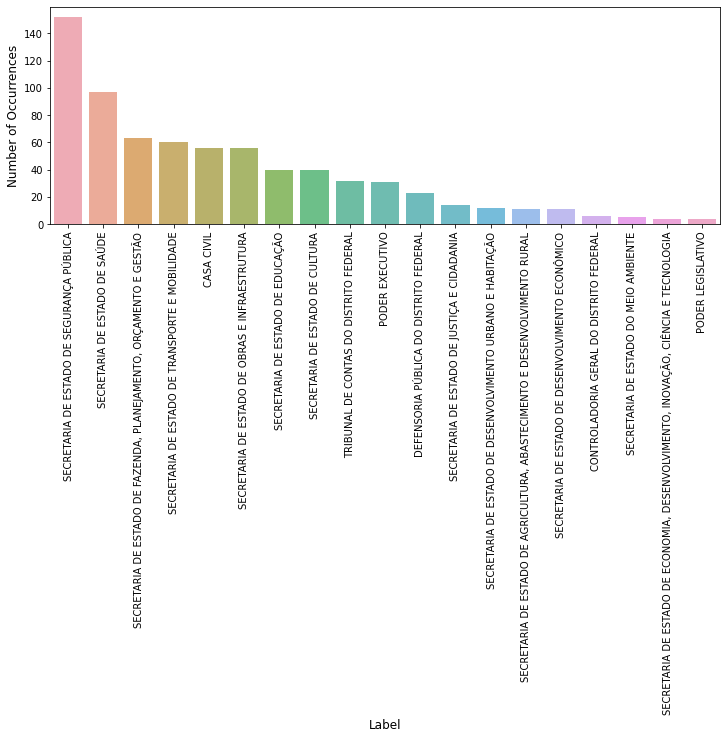

In [5]:
cnt_pro = dt_train['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [5]:
def print_do_text(index):
    example = dt_train[dt_train.index == index][['text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])
print_do_text(12)

O SECRETÁRIO DE ESTADO DE SAÚDE DO DISTRITO FEDERAL, no uso da atribuição que lhe
confere o Decreto nº 34.239, de 26 de março de 2013, publicado no DODF nº 63, de 27 de março de 2013
(fl. 2), Considerando o Contrato de Gestão nº 1/2014, firmado entre o Distrito Federal e o Instituto do
Câncer Infantil e Pediatria Especializada (ICIPE); Considerando o Parecer nº 355/2012 da
PROPES/PGDF, e Considerando o Decreto nº 34.155, de 21 de fevereiro de 2013, publicado no DODF
nº 39, de 22 de fevereiro de 2013 (pag. 13, item 9.30), o qual inclui o Hospital da Criança de Brasília
(HCB), José de Alencar, na estrutura da Secretária de Estado de Saúde do Distrito Federal, resolve:
Art. 1º Autorizar a cessão da servidora JOSEETE MENDONÇA MESQUITA DOS ANJOS, matrícula nº
159.241-6, ao HCB.
Art. 2º Para efeitos de controle de frequência, os servidores em questão serão cadastrados com status
"cedido" no Sistema ForPonto.
Art. 3º O HCB encaminhará mensalmente à Comissão de Acompanhamento do Contrato de Ge

Ref célula abaixo:
- https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess

In [6]:
######### É AQUI ###########
def cleanText(text):
    tokens = gensim.utils.simple_preprocess(text)
    return tokens
dt_train['text'] = dt_train['text'].apply(cleanText)
dt_val['text'] = dt_val['text'].apply(cleanText)

In [7]:
def reading_df(df):
    for i in range(len(df['text'])):
        return df['text'][i]

In [8]:
train_tagged = dt_train.apply(
    lambda r: TaggedDocument(words=reading_df(dt_train), tags=[r.label]), axis=1)
test_tagged = dt_val.apply(
    lambda r: TaggedDocument(words=reading_df(dt_val), tags=[r.label]), axis=1)

In [9]:
train_tagged.values[1]
train_corpus = list(train_tagged)
print(train_corpus[:2])

[TaggedDocument(words=['diretor', 'geral', 'do', 'departamento', 'de', 'trânsito', 'do', 'distrito', 'federal', 'no', 'uso', 'da', 'atribuição', 'prevista', 'no', 'art', 'do', 'decreto', 'nº', 'de', 'de', 'abril', 'de', 'que', 'regulamenta', 'os', 'arts', 'da', 'lei', 'complementar', 'nº', 'de', 'de', 'dezembro', 'de', 'conforme', 'processo', 'sei', 'nº', 'resolve', 'designar', 'juliana', 'maria', 'carpi', 'agente', 'de', 'trânsito', 'matrícula', 'para', 'substituir', 'natt', 'douglas', 'correa', 'agente', 'de', 'trânsito', 'matrícula', 'corregedor', 'símbolo', 'cne', 'da', 'corregedoria', 'do', 'detran', 'df', 'nos', 'períodos', 'de', 'por', 'motivo', 'de', 'férias', 'do', 'titular', 'fabrício', 'lima', 'de', 'andrade', 'moura'], tags=['SECRETARIA DE ESTADO DE SEGURANÇA PÚBLICA']), TaggedDocument(words=['diretor', 'geral', 'do', 'departamento', 'de', 'trânsito', 'do', 'distrito', 'federal', 'no', 'uso', 'da', 'atribuição', 'prevista', 'no', 'art', 'do', 'decreto', 'nº', 'de', 'de', 'a

In [10]:
test_tagged.values[1]
test_corpus = list(test_tagged)
print(test_corpus[:2])

[TaggedDocument(words=['contratante', 'banco', 'de', 'brasília', 'brb', 'promitente', 'contratada', 'digisec', 'certificação', 'digital', 'eireli', 'me', 'objeto', 'aquisição', 'de', 'chaves', 'criptográficas', 'certificados', 'digitais', 'para', 'pessoa', 'fisica', 'jurídica', 'para', 'servidor', 'de', 'rede', 'na', 'hierarquia', 'da', 'icp', 'brasil', 'com', 'garantia', 'conforme', 'especificações', 'técnicas', 'mínimas', 'do', 'edital', 'seus', 'anexos', 'bem', 'como', 'da', 'proposta', 'da', 'contratada', 'modalidade', 'da', 'contratação', 'pregão', 'eletrônico', 'brb', 'nº', 'vigência', 'de', 'itens', 'registrados', 'valor', 'signatários', 'pelo', 'brb', 'kátia', 'do', 'carmo', 'peixoto', 'de', 'queiroz', 'pela', 'contratada', 'eduardo', 'pereira', 'dos', 'santos', 'executor', 'kleber', 'ponce', 'leones', 'processo', 'nº', 'jean', 'felippe', 'mazépas', 'gerente', 'de', 'área'], tags=['SECRETARIA DE ESTADO DE FAZENDA, PLANEJAMENTO, ORÇAMENTO E GESTÃO']), TaggedDocument(words=['cont

In [13]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
model_test = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model_test.build_vocab(test_corpus)
model_test.train(test_corpus, total_examples=model_test.corpus_count, epochs=model.epochs)

In [15]:
vector = model.infer_vector(['secretaria', 'ordeno'])
print(vector)

[-0.00467879 -0.00805296 -0.00017565  0.00962239  0.00614028 -0.00245098
 -0.0098388  -0.00480496  0.00724424 -0.00063515  0.00012743  0.0075782
 -0.00710821 -0.00276915  0.00424255 -0.00160972 -0.00631915 -0.00989535
  0.00200098  0.00157338 -0.00345848  0.00889231 -0.00203    -0.00865846
 -0.0078123   0.00462034 -0.00682369  0.00876927 -0.00885721 -0.00450971
 -0.00939423 -0.00939894 -0.00795661  0.00667999 -0.00029351  0.00030075
 -0.0081424  -0.00750042 -0.00882855  0.00834761 -0.00583171  0.00854066
 -0.00115715 -0.00399611 -0.00738681 -0.00866102 -0.00730485  0.00026275
  0.00737067 -0.00369325]


In [16]:
model.wv.most_similar('abril')

[('nº', 0.3428289294242859),
 ('no', 0.3298179507255554),
 ('federal', 0.3096495568752289),
 ('lei', 0.2995016574859619),
 ('distrito', 0.2984026372432709),
 ('complementar', 0.27970370650291443),
 ('dezembro', 0.27346861362457275),
 ('conforme', 0.26506608724594116),
 ('sei', 0.2595835328102112),
 ('atribuição', 0.2558593153953552)]

In [17]:
model.wv.vocab

{'diretor': <gensim.models.keyedvectors.Vocab at 0x7fda446e5c50>,
 'geral': <gensim.models.keyedvectors.Vocab at 0x7fda446e5ba8>,
 'do': <gensim.models.keyedvectors.Vocab at 0x7fda446e5a90>,
 'departamento': <gensim.models.keyedvectors.Vocab at 0x7fda446e5a58>,
 'de': <gensim.models.keyedvectors.Vocab at 0x7fda446e5ac8>,
 'trânsito': <gensim.models.keyedvectors.Vocab at 0x7fda446e5a20>,
 'distrito': <gensim.models.keyedvectors.Vocab at 0x7fda446e59e8>,
 'federal': <gensim.models.keyedvectors.Vocab at 0x7fda446e59b0>,
 'no': <gensim.models.keyedvectors.Vocab at 0x7fda446e5978>,
 'uso': <gensim.models.keyedvectors.Vocab at 0x7fda446e5940>,
 'da': <gensim.models.keyedvectors.Vocab at 0x7fda446e5908>,
 'atribuição': <gensim.models.keyedvectors.Vocab at 0x7fda446e58d0>,
 'prevista': <gensim.models.keyedvectors.Vocab at 0x7fda446e5898>,
 'art': <gensim.models.keyedvectors.Vocab at 0x7fda446e5860>,
 'decreto': <gensim.models.keyedvectors.Vocab at 0x7fda446e5828>,
 'nº': <gensim.models.keyedve